# Анализ бизнес-показателей сервиса Яндекс. Афиша.

Задача - помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет. Необходимо изучить как клиенты пользуются сервисом, когда делают первые покупки на сайте, сколько денег приносит компании каждый клиент, когда расходы на привлечение клиента окупаются.

## Изучение данных из файла. Предобработка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    url = 'https://drive.google.com/file/d/1TvJ5eGUaw1sW0SAf3Q_DBOuLwvcOeIar/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    visits = pd.read_csv(path)
except:    
    raise

In [3]:
try:
    url1= 'https://drive.google.com/file/d/1yrm6_RBQa3sI_juyybfWl2x7bsmEutEZ/view?usp=sharing'
    path1 = 'https://drive.google.com/uc?export=download&id='+url1.split('/')[-2]
    orders = pd.read_csv(path1)
except:    
    raise

In [4]:
try:
    url2= 'https://drive.google.com/file/d/1hiLMmpGUtM-__3audqdqokkpK26KwjvK/view?usp=sharing'
    path2 = 'https://drive.google.com/uc?export=download&id='+url2.split('/')[-2]
    costs = pd.read_csv(path2)
except:    
    raise

Импортируем основные библиотеки и прочтем датасеты с данными о визитах, расходах и затратах. Запишем их в датасеты visits, orders и  costs.

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
visits.sample(3)

,Device,End Ts,Source Id,Start Ts,Uid
17681,desktop,2017-10-19 08:32:00,3,2017-10-19 08:30:00,6071323297553121685
273522,desktop,2017-10-14 09:51:00,2,2017-10-14 09:18:00,7281335262769860702
253790,touch,2018-03-29 19:50:00,5,2018-03-29 19:50:00,1035874967028223263


Выведем информацию о датасете visits и 3 случайных записи датасета. Перед детальным изучением каждого поля преобразуем наименования столбцов в строчные буквы без пробелов.

In [7]:
new_visits_names = ['device', 'end_ts', 'source_id', 'start_ts','uid']
visits.set_axis(new_visits_names, axis = 'columns', inplace = True)

In [8]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [9]:
cols = visits.columns[:4]
for col in visits.columns:
    pct_missing = np.mean(visits[col].isna())
    print('{} - {}%'.format(col, pct_missing*100))

device - 0.0%
end_ts - 0.0%
source_id - 0.0%
start_ts - 0.0%
uid - 0.0%


Поле device показывает с какого из двух основных устройств был осуществлен вход и не содержит пропусков. Поле имеет тип object. Приведем его к типу category. 

In [10]:
visits['device'].astype('category')

0           touch
1         desktop
2           touch
3         desktop
4         desktop
           ...   
359395    desktop
359396      touch
359397    desktop
359398    desktop
359399      touch
Name: device, Length: 359400, dtype: category
Categories (2, object): [desktop, touch]

In [11]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

Метод value_counts показывает, что со стационарных устройств на Яндекс. Афишу заходит примерно в 2,5 раза больше пользователей, чем с мобильных устройств.

Поле end_ts не имеет пропусков, но его необходимо привести к формату даты-времени.

In [12]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y/%m/%dT%H:%M:%S')

In [13]:
visits['end_ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

Границы дат не соотвествтуют анализируемому диапазону (с июня 2017 по конец мая 2018 года), т.к. максимальная дата окончания сессии - 2018-06-01, а это уже июнь 2018. Для чистоты анализа перезапишем датафрейм как срез, в котором end_ts не превышает 31 мая 2018.

In [14]:
visits = visits[(visits['end_ts'])< '2018-06-01 00:00:00']

In [15]:
visits['end_ts'].describe()

count                  359388
unique                 224749
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-05-31 23:59:00
Name: end_ts, dtype: object

Данные успешно отфильтрованы, дата окончания сессии - не больше 31 мая.

In [16]:
visits['source_id'].value_counts()

4     101790
3      85609
5      66903
2      47624
1      34119
9      13277
10     10024
7         36
6          6
Name: source_id, dtype: int64

Исследуем поле с идентификаторами источников перехода на сайт. Пропусков нет, тип данных - int, в преобразовании типа не нуждается.

Поле start_ts аналогично end_ts не имеет пропусков. Приведем его к типу даты.

In [17]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y/%m/%dT%H:%M:%S')

In [18]:
visits['start_ts'].describe()

count                  359388
unique                 224300
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

Проверим поле start_ts на соответствие диапазону дат, указанному в анализе. После фильтрации датафрейма по полю end_ts крайние значения start_ts лежат строго в указанном диапазоне.

Поле uid не имеет пропусков. Тип поля - uint64 (целые числа без знака со значениями от 0 до 18446744073709500000). Изменения типа не требуется.

In [19]:
visits.duplicated(keep='first').sum()

0

Проверим датафрейм на наличие дубликатов. Зададим аргумент keep = 'first', первое повторение строки не будет считаться дубликатом. Метод Duplicated возвращает 0, в датафреймем нет  дублирующихся строк.

In [20]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [21]:
orders.sample(3)

,Buy Ts,Revenue,Uid
15555,2017-10-31 20:42:00,2.11,7241800382209370494
19339,2017-11-24 15:26:00,0.67,15262379446369645536
40783,2018-03-20 15:38:00,18.33,9387424324786966491


Приведем наименования столбцов к наименованиям строчными буквами и без пробелов.

In [22]:
new_orders_names = ['buy_ts', 'revenue','uid']
orders.set_axis(new_orders_names, axis = 'columns', inplace = True)

Поле buy_ts требует приведения к формату даты-времени.

In [23]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y/%m/%dT%H:%M:%S')

In [24]:
cols = orders.columns[:2]
for col in orders.columns:
    pct_missing = np.mean(orders[col].isna())
    print('{} - {}%'.format(col, pct_missing*100))

buy_ts - 0.0%
revenue - 0.0%
uid - 0.0%


Пропущенных значений нет. 

In [25]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

В датафрейме orders есть покупки, датируемые июнем 2018. Отфильтруем датафрейм таким образом, чтобы они не попадали в него.

In [26]:
orders = orders[(orders['buy_ts'])< '2018-06-01 00:00:00']

In [27]:
orders['buy_ts'].describe()

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

Теперь данные в датафрейме соответствуют анализируемому периоду.

Также нет пропусков и в полях revenue и uid. Поле revenue имеет тип float и не нуждается в изменении типа. Поле uid имеет тип uint64 и также не нуждаетсяс в изменении типа.

In [28]:
orders.duplicated(keep='first').sum()

0

Датафрейм orders не содержит дублирующих строк.

In [29]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [30]:
costs.sample(3)

,source_id,dt,costs
1490,5,2017-07-09,77.58
19,1,2017-06-20,25.37
810,3,2017-08-24,215.38


In [31]:
cols = costs.columns[:2]
for col in costs.columns:
    pct_missing = np.mean(costs[col].isna())
    print('{} - {}%'.format(col, pct_missing*100))

source_id - 0.0%
dt - 0.0%
costs - 0.0%


Все поля датасета не имеют пропусков. Наименования полей также не нуждаются в приведении к формату со строчными буквами без пробелов. Типы полей source_id и costs - int и float, предобработка не требуется. Поле dt необходимо привести к формату даты.

In [32]:
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y/%m/%d')

In [33]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Данные в датафрейме соответствуют анализируемому периоду.

In [34]:
costs.duplicated(keep = 'first').sum()

0

Датафрейм costs не содержит дублирующих строк.

## Расчет и анализ основных метрик. 

### Расчет продуктовых метрик

#### Расчет и анализ метрик DAU, MAU и WAU

In [35]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_day'] = visits['start_ts'].astype('datetime64[D]')

Для расчета "метрик тщеславия" добавим в датасет visits столбцы с годом, месяцем, неделей и днем начала сессии пользователей в Яндекс.Афише. 

In [36]:
mau = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
int(mau)

23227

Среднемесячное количество уникальных пользователей за период с июня 2017 по конец мая 2018 - 23 227 человек. Оценим, как менялось количество пользователей каждый месяц.

In [37]:
mau_month = visits.groupby('session_month').agg({'uid':'nunique'})
mau_month

,uid
session_month,
2017-06-01,13259
2017-07-01,14183
2017-08-01,11631
2017-09-01,18975
2017-10-01,29692
2017-11-01,32797
2017-12-01,31557
2018-01-01,28716
2018-02-01,28749


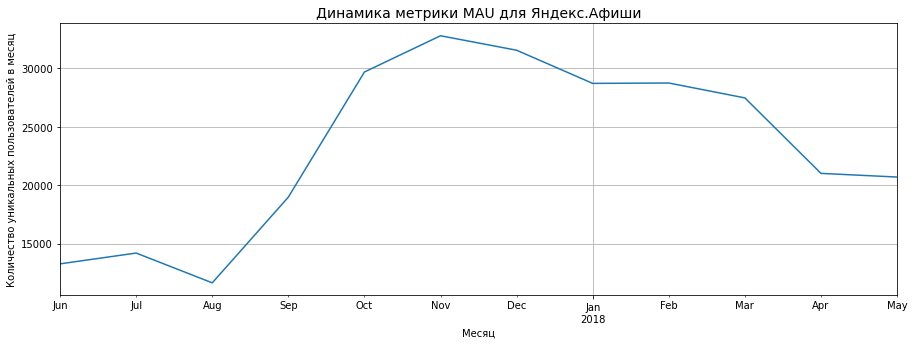

In [38]:
mau_month.plot(figsize = (15,5),grid = True).legend().set_visible(False)
plt.xlabel("Месяц")
plt.ylabel("Количество уникальных пользователей в месяц")
plt.title('Динамика метрики MAU для Яндекс.Афиши', fontsize = 14);

Из таблицы с помесячным распределением и из графика видно, что с 2017 года количество посетителей сайта значительно выросло (13 259 в июне 2017 и 20 701 в мае 2018, также mau за первое полугодие 2018 ближе к среднемесячному mau, 23228). Резкий рост, начиная с осенних месяцев и до новогодних праздников можно объяснить тем, что в холодное время года люди более склонны к посещению концертов, театров и кинотеатров, основные гастрольные туры также в большей степени проходят в это время (гипотеза). Спад в весенне-летний период скорее всего связан с сезоном отпусков и желанием проводить больше времемни на открытом воздухе (также гипотеза). Для проверки этих гипотез имеющихся данных недостаточно.

In [39]:
wau = visits.groupby('session_week').agg({'uid':'nunique'}).mean()
int(wau)

5724

Средненедельное количество уникальных посетителей - 5724. Проанализируем распределение за весь период и построим диаграмму.

In [40]:
wau_month = visits.groupby('session_week').agg({'uid':'nunique'})
wau_month

,uid
session_week,
2017-06-01,4082
2017-06-08,3311
2017-06-15,2844
2017-06-22,3079
2017-06-29,3055
2017-07-06,3563
2017-07-13,4790
2017-07-20,2978
2017-07-27,2505


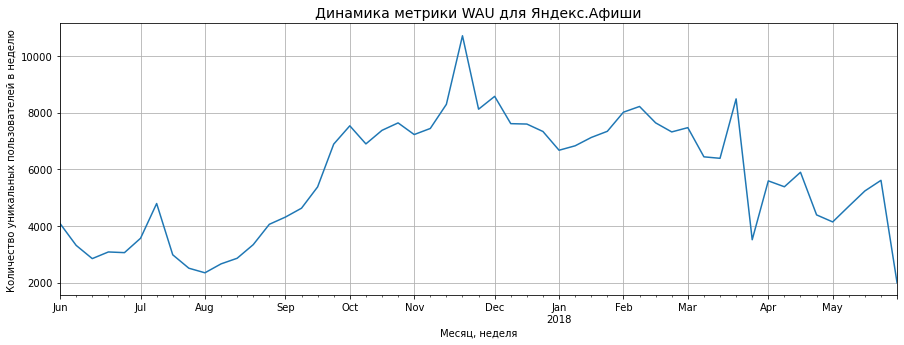

In [41]:
wau_month.plot(figsize = (15,5),grid = True).legend().set_visible(False)
plt.xlabel("Месяц, неделя")
plt.ylabel("Количество уникальных пользователей в неделю")
plt.title('Динамика метрики WAU для Яндекс.Афиши', fontsize = 14);

Распределение и график показывают самые высокие значения посещений сайта с 40 по 52 (последнюю в году) неделю. Это частично подтверждает гипотезу о том, что в осенний и предновогодний период людид активно посещают развлекательные мероприятия. Начиная с новогодних праздников посещаемость идет на спад. Небольшие пики наблюдаются в период праздников 23 февраля и 8 марта.

In [42]:
dau = visits.groupby('session_day').agg({'uid':'nunique'}).mean()
int(dau)

907

Среднедневное количество уникальных пользователей - 907.

In [43]:
dau_month = visits.groupby('session_day').agg({'uid':'nunique'})
dau_month.sample(10)

,uid
session_day,
2017-06-26,564
2017-12-19,1164
2018-05-18,893
2017-11-10,1197
2017-06-05,820
2017-11-23,1433
2017-08-26,409
2017-11-13,1413
2018-02-21,1285


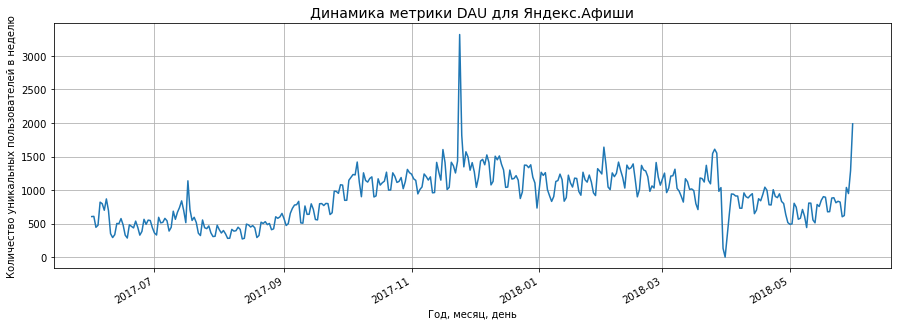

In [44]:
dau_month.plot(figsize = (15,5),grid = True).legend().set_visible(False)
plt.xlabel("Год, месяц, день")
plt.ylabel("Количество уникальных пользователей в неделю")
plt.title('Динамика метрики DAU для Яндекс.Афиши', fontsize = 14);

Распределение дневных посещений напоминает синусоиду и скорее всего связано с днями недели (выходные и будние дни).

In [45]:
wsf = int(dau)/int(wau)
print('Sticky Factor за неделю: {:.1%}'.format(wsf))


Sticky Factor за неделю: 15.8%


In [46]:
msf = int(dau)/int(mau)
print('Sticky Factor за месяц: {:.1%}'.format(msf))


Sticky Factor за месяц: 3.9%


#### Определение среднего количества сессий в день.

In [47]:
session_df = visits.groupby(['session_year','session_month', 'session_day']).agg({'uid': ('count', 'nunique')})
session_df.columns = ['n_sessions', 'n_users']
session_df['sess_per_user'] = (session_df['n_sessions']/session_df['n_users'])

Создадим вспомогательный датафрейм session_df с группировкой по дням, уникальным пользователям и подсчетом количества сессий. Добавим вычисляемый столбец sess_per_user, в котором посчитаем среднее количество сессий на пользователя за 1 день. 

In [48]:
session_df['sess_per_user'].mean()

1.082167111295187

Среднее количество сессий в день за анализируемый период = 1.0822

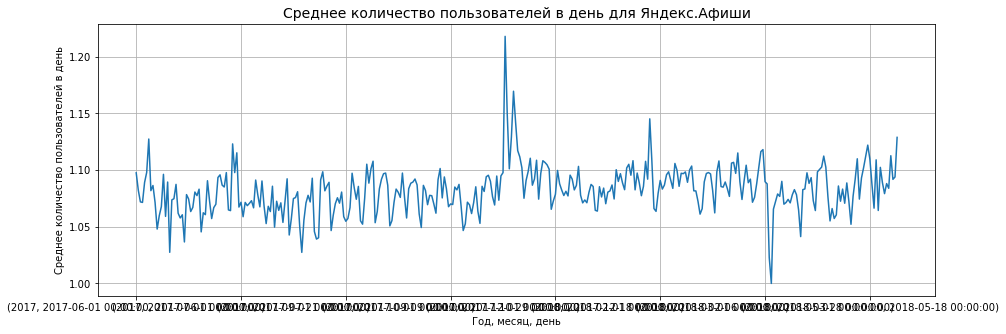

In [49]:
session_df['sess_per_user'].plot(figsize = (15,5),grid = True).legend().set_visible(False)
plt.xlabel("Год, месяц, день")
plt.ylabel("Среднее количество пользователей в день")
plt.title('Среднее количество пользователей в день для Яндекс.Афиши', fontsize = 14);

#### Анализ продолжительности средней пользовательской сессии.

In [50]:
visits['session_duration_sec'] = (
    visits['end_ts'] - visits['start_ts']
).dt.seconds

Добавим в датафрейм visits расчет длины для каждой сессии в секундах.

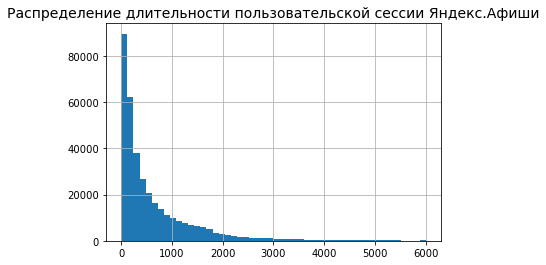

In [51]:
visits['session_duration_sec'].hist(bins = 50, range = (0,6000))
plt.title('Распределение длительности пользовательской сессии Яндекс.Афиши', fontsize = 14);

Гистограмма показывает сессию около минуты, как наиболее часто встречающуюся. Проверим эту гипотезу. Посчитаем моду распределения.

In [52]:
mode_session = visits['session_duration_sec'].mode()
mode_session

0    60
dtype: int64

Вывод - типичная пользовательская сессия на сервисе Яндекс.Афиша длится 60 секунд.

#### Когортный анализ и расчет Retention Rate.

С учетом того, что период анализа - год, предлагается анализировать месячные, а не недельные когорты.

In [53]:
first_activity_time = visits.groupby(['uid'])['start_ts'].min()
first_activity_time.name = 'first_activity_time'
visits = visits.join(first_activity_time, on='uid')

Возьмём дату, когда пользователь впервые зашел в приложение Яндекс.Афиша. Сгруппируем датасет orders по пользователям (uid) и найдем минимальную дату. Запишем это в объект Series first_activity_date и объединим столбец с датафреймом orders.

In [54]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_session_month'] = visits['first_activity_time'].astype('datetime64[M]')
visits.sample(3)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,session_duration_sec,first_activity_time,first_session_month
24032,desktop,2018-04-16 11:22:00,3,2018-04-16 11:22:00,4196622029976536117,2018,2018-04-01,2018-04-12,2018-04-16,0,2018-04-16 11:22:00,2018-04-01
78003,desktop,2018-01-31 13:06:00,10,2018-01-31 12:41:00,4982163981744147559,2018,2018-01-01,2018-01-25,2018-01-31,1500,2018-01-31 12:41:00,2018-01-01
41778,desktop,2018-02-26 12:34:00,5,2018-02-26 12:33:00,325320750514679,2018,2018-02-01,2018-02-22,2018-02-26,60,2017-09-30 14:29:00,2017-09-01


Добавим столбец с месяцем первого посещения. Приведем first_activity_date к месяцу (первому числу месяца). Также добавим столбец с месяцами для любого заказа, применим метод datetime64[M] к столбцу order_month.

In [55]:
visits['cohort_lifetime'] = ((visits['session_month'] - visits['first_session_month']) / np.timedelta64(1, 'M')).round().astype(int)
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,session_duration_sec,first_activity_time,first_session_month,cohort_lifetime
330349,touch,2018-04-05 09:27:00,4,2018-04-05 09:24:00,15626366850549834593,2018,2018-04-01,2018-04-05,2018-04-05,180,2018-04-05 09:24:00,2018-04-01,0
303321,desktop,2017-11-24 16:19:00,4,2017-11-24 16:15:00,10629146027540444721,2017,2017-11-01,2017-11-23,2017-11-24,240,2017-11-24 16:15:00,2017-11-01,0
223618,desktop,2018-04-20 16:28:00,2,2018-04-20 16:23:00,4287425452172179795,2018,2018-04-01,2018-04-19,2018-04-20,300,2017-06-19 14:22:00,2017-06-01,10
235769,touch,2018-05-08 19:37:00,4,2018-05-08 19:17:00,5799704151645903820,2018,2018-05-01,2018-05-03,2018-05-08,1200,2018-05-08 19:17:00,2018-05-01,0
178276,desktop,2018-02-27 21:13:00,4,2018-02-27 21:00:00,9043621446040952403,2018,2018-02-01,2018-02-22,2018-02-27,780,2018-02-27 21:00:00,2018-02-01,0


Посчитаем lifetime в месяцах и переведем в целое число.

In [56]:
visits.sample(3)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,session_duration_sec,first_activity_time,first_session_month,cohort_lifetime
324347,touch,2017-11-20 08:46:00,4,2017-11-20 08:44:00,3025590040656343403,2017,2017-11-01,2017-11-16,2017-11-20,120,2017-11-20 08:44:00,2017-11-01,0
22448,touch,2017-11-27 23:23:00,4,2017-11-27 23:22:00,17941638962410652331,2017,2017-11-01,2017-11-23,2017-11-27,60,2017-06-30 21:11:00,2017-06-01,5
106194,desktop,2018-01-23 11:38:00,4,2018-01-23 11:14:00,335745858575465229,2018,2018-01-01,2018-01-18,2018-01-23,1440,2017-10-25 18:18:00,2017-10-01,3


In [57]:
cohorts = visits.groupby(['first_session_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

cohorts

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на месяц.

In [58]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']].rename(
    columns={'uid':'cohort_users'})
initial_users_count

,first_session_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю.

In [59]:
cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Переименуем столбец uid в cohort_users. Объединим данные по когортам с исходным количеством пользователей в когорте. Добавим расчетный столбец с retention.

In [60]:
retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

In [61]:
retention_pivot.fillna(0)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,0.000000
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,0.000000,0.000000
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,0.000000,0.000000,0.000000
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,0.000000,0.000000,0.000000,0.000000
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,0.000000,0.000000,0.000000,0.000000,0.000000
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-02-01,1.0,0.057080,0.025454,0.020093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Построим сводную таблицу с показателем Retention Rate. Nan заменим на нули. Также заменим наименования столбцов, чтобы убрать двойные индексы

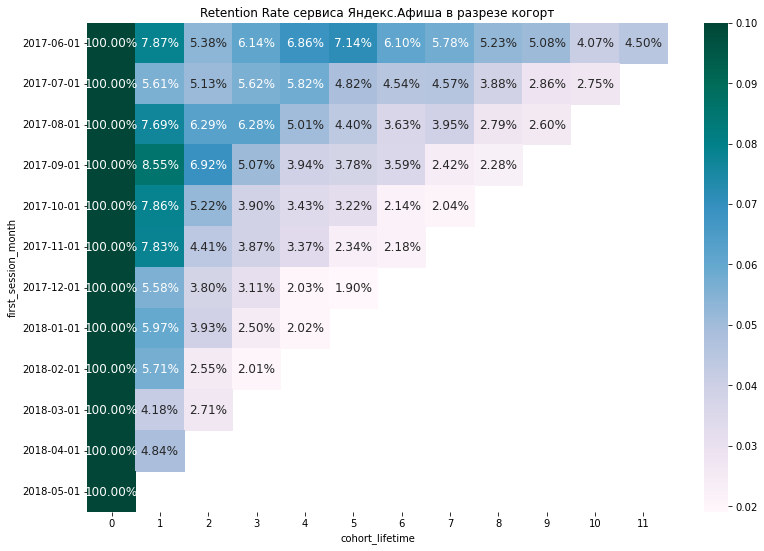

In [62]:
plt.figure(figsize=(13, 9))
plt.title('Retention Rate сервиса Яндекс.Афиша в разрезе когорт')
ax = sns.heatmap(
    retention_pivot,
    annot=True,
    fmt='.2%',
    cmap = 'PuBuGn',    
    vmax=.1,
    annot_kws={'fontsize':12}
)
ticklabels=[retention_pivot.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);

Retention Rate имеет тенденцию к снижению с течением времени. Наиболее стабильна первая (июньская) когорта. Можно также отметить сентябрьскую когорту, как удерживающую максимальную посещаемость на второй и третий месяц существования.

In [63]:
retention_pivot.columns = ['0', '1', '2','3','4','5','6','7','8','9','10','11',]
retention_pivot.reset_index()

,first_session_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
1,2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2,2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
3,2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
4,2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
5,2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
6,2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-03-01,1.0,0.041818,0.027053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
retention_pivot=retention_pivot.reset_index()
retention_mean_2nd_month = retention_pivot['1'].mean()
print('Средний Retention Rate на второй месяц жизни когорт: {:.1%}'.format(retention_mean_2nd_month))

Средний Retention Rate на второй месяц жизни когорт: 6.5%


### Метрики электронной коммерции

#### Расчет среднего времени с момента первого посещения сайта до совершения покупки

In [65]:
vdf = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
vdf.sample(5)

,uid,start_ts
17177,1393905606149702726,2018-05-17 08:10:00
104586,8442780768762514758,2017-10-08 21:38:00
186259,15055696678458025081,2017-09-05 21:31:00
113429,9168972807057557761,2018-02-16 13:53:00
95590,7716799829652400234,2017-09-04 15:59:00


Для расчета среднего времени с момента первого посещения сайта запишем в датафрейм vdf сгруппированные по уникальным id первые входы пользователей на сайт.

In [66]:
odf = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
odf.sample(5)

,uid,buy_ts
14478,7260386985898848362,2017-12-06 14:57:00
4965,2512783339283858751,2018-02-12 21:19:00
2437,1249701772943029990,2017-08-21 13:43:00
10601,5340038410512104746,2018-05-04 23:02:00
30746,15497854195519390117,2017-11-20 15:30:00


Аналогично, создадим датафрейм odf, в который запишем первые покупки каждого уникального id.

In [67]:
vodf = vdf.merge(odf)
vodf.sample(3)

,uid,start_ts,buy_ts
8032,4053919273039663259,2017-11-28 23:14:00,2017-11-28 23:34:00
13803,6925113827354942950,2017-12-30 09:49:00,2017-12-30 09:51:00
9169,4634125973373043575,2018-03-21 11:50:00,2018-03-21 11:50:00


Объединим датафреймы odf и vdf, чтобы получить в одном датафрейме дату первого входа и дату первой покупки для каждого уникального пользователя.

In [68]:
vodf['buy_time'] = (vodf['buy_ts'] - vodf['start_ts']).astype('timedelta64[s]')
vodf.sample(10)

,uid,start_ts,buy_ts,buy_time
3344,1701463350854217496,2017-12-16 17:15:00,2017-12-16 17:39:00,1440.0
19932,10075911879844440863,2017-07-25 12:53:00,2017-09-03 22:02:00,3488940.0
35129,17723701539638833318,2017-10-03 16:19:00,2017-10-03 16:28:00,540.0
11695,5862907005116920831,2017-12-29 16:55:00,2017-12-29 16:59:00,240.0
30264,15256449124017488539,2017-08-03 03:01:00,2017-08-03 03:05:00,240.0
26601,13444092817049362305,2017-10-02 13:15:00,2017-10-02 14:04:00,2940.0
10734,5407784605606132013,2017-06-08 13:57:00,2017-06-08 13:57:00,0.0
23720,11986694632804387918,2018-01-03 19:38:00,2018-01-03 19:45:00,420.0
16997,8549447196963437835,2017-09-04 10:07:00,2017-09-04 10:12:00,300.0
28276,14281930256075678403,2018-02-13 18:57:00,2018-02-13 22:24:00,12420.0


Посчитаем разницу в секундах между временем покупки и первым посещением сайта с помощью метода timedelta для каждого уникального пользователя.

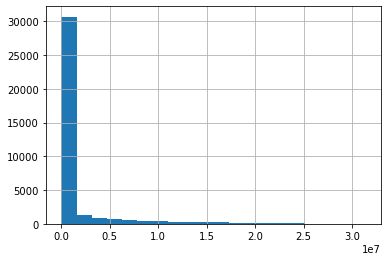

In [69]:
vodf['buy_time'].hist(bins =20);

На распределении явно видно, что более точное значение типичного времени от посещения до покупки - это мода. Посчитаем ее, медиану и среднее.

In [70]:
mode_buy_time = vodf['buy_time'].mode()

In [71]:
median_buy_time = vodf['buy_time'].median()

In [72]:
mean_buy_time = vodf['buy_time'].mean()

In [73]:
mode_buy_time

0    60.0
dtype: float64

In [74]:
median_buy_time

960.0

In [75]:
mean_buy_time

1460450.5322819122

Вывод - типичное время от первого посещения до покупки на сайте Яндекс.Афиша - 60 секунд.

#### Расчет среднего количества покупок на одного покупателя

In [76]:
first_order_date = orders.groupby(['uid'])['buy_ts'].min()
first_order_date.name = 'first_order_date'
orders = orders.join(first_order_date, on='uid')
orders.sample(5)

,buy_ts,revenue,uid,first_order_date
10062,2017-10-02 11:08:00,3.05,7611571101796206396,2017-10-02 11:08:00
38346,2018-03-05 17:52:00,0.12,9324349585487192579,2017-08-19 23:05:00
44843,2018-04-20 17:30:00,6.11,16068748186047770670,2018-04-20 17:30:00
34573,2018-02-13 16:22:00,12.22,5903483803076879059,2018-02-13 15:22:00
130,2017-06-02 12:20:00,3.67,1351361558057820554,2017-06-02 12:20:00


Возьмём дату, когда пользователь впервые совершил покупку. Сгруппируем датасет orders по пользователям (uid) и найдем минимальную дату. Запишем это в объект Series first_order_date и объединим столбец с датафреймом orders.

In [77]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

Добавим столбец с первым месяцем покупки.

In [78]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

Добавим столбец с месяцем покупки.

In [79]:
orders['cohort_lifetime'] = ((orders['order_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int)
orders.sample(5)

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,cohort_lifetime
5943,2017-08-24 12:22:00,21.39,3924936134222050344,2017-08-24 12:22:00,2017-08-01,2017-08-01,0
35884,2018-02-20 11:46:00,0.70,12901497024900258982,2018-02-20 11:46:00,2018-02-01,2018-02-01,0
886,2017-06-07 22:51:00,0.30,13890186445704875571,2017-06-07 21:16:00,2017-06-01,2017-06-01,0
20989,2017-11-29 19:40:00,3.67,13232040431316027411,2017-11-29 19:40:00,2017-11-01,2017-11-01,0
48757,2018-05-24 11:57:00,0.43,82165444601562947,2017-12-23 19:19:00,2017-12-01,2018-05-01,5


Добавим столбец с lifetime, посчтаем его в месяцах и переведем в целое число.

In [80]:
qty_clients = orders.pivot_table(index = ['first_order_month','cohort_lifetime'] , values = 'uid', aggfunc = 'count').reset_index()
qty_clients

,first_order_month,cohort_lifetime,uid
0,2017-06-01,0,2354
1,2017-06-01,1,177
2,2017-06-01,2,174
3,2017-06-01,3,226
4,2017-06-01,4,292
...,...,...,...
73,2018-03-01,1,178
74,2018-03-01,2,176
75,2018-04-01,0,2495
76,2018-04-01,1,195


In [81]:
cohorts_mean_sales= orders.pivot_table(index = ['first_order_month','cohort_lifetime'], values ='uid', aggfunc = [lambda u: u.nunique(), 'count']).reset_index()
cohorts_mean_sales.columns = ['first_order_month','cohort_lifetime','users', 'orders']
cohorts_mean_sales['order_per_user'] = cohorts_mean_sales['orders']/cohorts_mean_sales['users']
cohorts_mean_sales

,first_order_month,cohort_lifetime,users,orders,order_per_user
0,2017-06-01,0,2023,2354,1.163618
1,2017-06-01,1,61,177,2.901639
2,2017-06-01,2,50,174,3.480000
3,2017-06-01,3,54,226,4.185185
4,2017-06-01,4,88,292,3.318182
...,...,...,...,...,...
73,2018-03-01,1,90,178,1.977778
74,2018-03-01,2,58,176,3.034483
75,2018-04-01,0,2276,2495,1.096221
76,2018-04-01,1,69,195,2.826087


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество покупателей в месяц.

In [82]:
cohorts_mean_sales_total = cohorts_mean_sales.pivot_table(index = 'first_order_month', columns = 'cohort_lifetime',values ='order_per_user',  aggfunc = 'mean')

In [83]:
cohorts_mean_sales_total

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07-01,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08-01,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09-01,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10-01,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сформируем сводную таблицу со средним заказом в разрезе когорт.

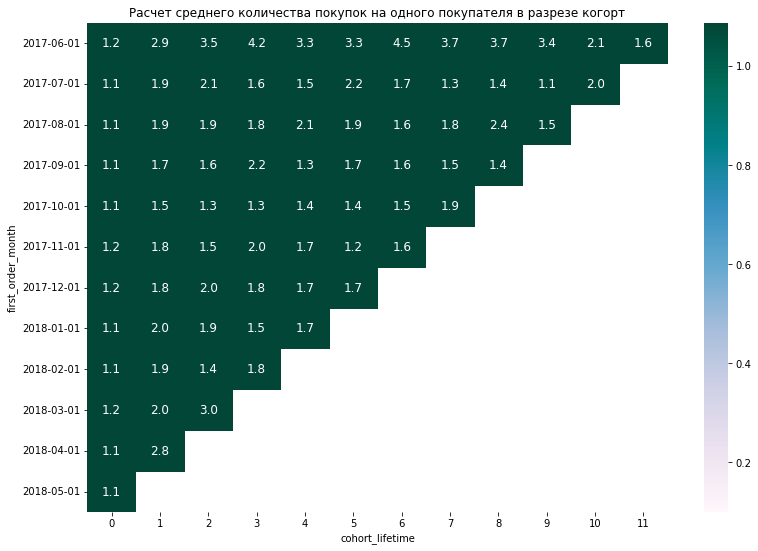

In [84]:
plt.figure(figsize=(13, 9))
plt.title('Расчет среднего количества покупок на одного покупателя в разрезе когорт')
ax = sns.heatmap(
    cohorts_mean_sales_total,
    annot=True,
    fmt='.1f',
    cmap = 'PuBuGn',    
    vmax=.1,
    annot_kws={'fontsize':12}
)
ticklabels=[cohorts_mean_sales_total.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);

Проанализируем среднее количество покупок на одного пользователя. Минимальное количество заказов происходит в первый месяц жизни когорты. Со временем почти в каждой когорте количество средних покупок на 1 пользователя растет. Первая когорта (июнь 2017 г). показывает максимальные показатели по заказам на пользователя.

In [85]:
cohorts_mean_sales_total.columns = ['0', '1', '2','3','4','5','6','7','8','9','10','11',]
cohorts_mean_sales_total.reset_index()

,first_order_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
1,2017-07-01,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2,2017-08-01,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
3,2017-09-01,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
4,2017-10-01,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
5,2017-11-01,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
6,2017-12-01,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-02-01,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-03-01,1.168978,1.977778,3.034483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
m6_cum_mst = cohorts_mean_sales_total['5'].mean()
m6_cum_mst

1.9112342812877965

Среднее количество покупок на 1 человека за 6 месяцев = 1,91.

#### Анализ среднего чека покупателя

In [87]:
average_receipt_df = orders.groupby('order_month').agg({'revenue': 'sum', 'uid': 'count'})

Сгруппируем датафрейм orders_for_ret по месяцам заказа и посчитаем суммарную выручку и количество пользователей.

In [88]:
average_receipt_df['avg_check'] = average_receipt_df['revenue']/average_receipt_df['uid']

Добавим столбец avg_check, в котором посчитаем выручку на 1 пользователя.

In [89]:
average_receipt = orders['revenue'].mean()
average_receipt

4.9996782639742445

Средняя выручка на 1 пользователя - 5 условных единиц.

In [90]:
average_receipt_df

,revenue,uid,avg_check
order_month,,,
2017-06-01,9557.49,2354,4.060106
2017-07-01,12539.47,2363,5.306589
2017-08-01,8758.78,1807,4.847139
2017-09-01,18345.51,3387,5.416448
2017-10-01,27987.70,5679,4.928280
2017-11-01,27069.93,5659,4.783518
2017-12-01,36388.60,6218,5.852139
2018-01-01,19417.13,4721,4.112927
2018-02-01,25560.54,5281,4.840095


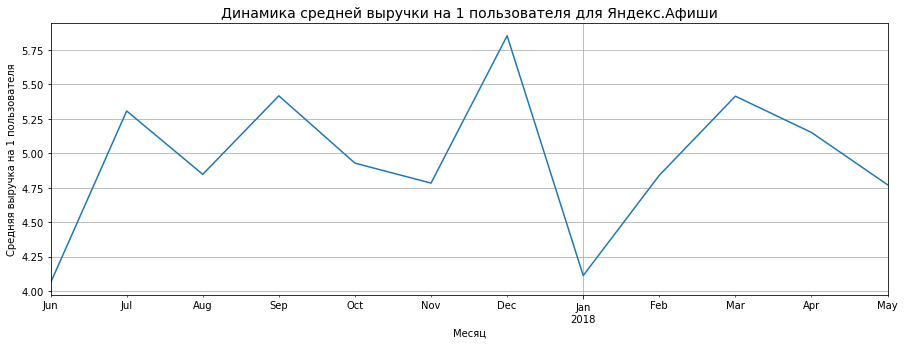

In [91]:
average_receipt_df['avg_check'].plot(figsize = (15,5),grid = True).legend().set_visible(False)
plt.xlabel("Месяц")
plt.ylabel("Средняя выручка на 1 пользователя")
plt.title('Динамика средней выручки на 1 пользователя для Яндекс.Афиши', fontsize = 14);

В динамике средняя выручка выглядит следующим образом. Максимальные значения она принимает в декабре, сентябре, июле и марте. Минимальное - в январе.

#### Анализ LTV на 1 покупателя в разрезе когорт.

In [92]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

Сформируем месяц первой покупки и назовем столбец first_order_month.

In [93]:
cohort_sizes = (
    orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Посчитаем количество новых покупателей за каждый месяц. 

In [94]:
cohorts = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и получим суммарную выручку.

In [95]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

Добавим в таблицу cohorts данные о том, сколько пользователей первый раз сделали заказ в каждом месяце.

In [96]:
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Маржинальность сервиса равна 100%, запишем это в переменную margin_rate. Добавим столбец с валовой прибылью, т.к. маржинальность - 100%, он будет равен выручке. Найдем разницу в месяцах между первым месяцем заказа и месяцем заказа. Округлим до целого числа.

In [97]:
report['ltv'] = report['gp'] / report['n_buyers']

Добавим вычисляемый столбец с ltv, поделив валовую прибыль на количество покупателей.

In [98]:
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).round(2)

output.fillna('')
output=output.cumsum(axis=1)
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выведем сводную с ltv в разрезе когорт.

In [99]:
m6_cum_ltv = output[5].mean()

Посчитаем средний ltv за 6 месяцев после первой покупки.

In [100]:
print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)

Средний LTV за 6 месяцев после первой покупки: 7.970000000000001


В среднем каждый покупатель за 6 месяцев жизни когорты принес 7,97 условных единиц прибыли.

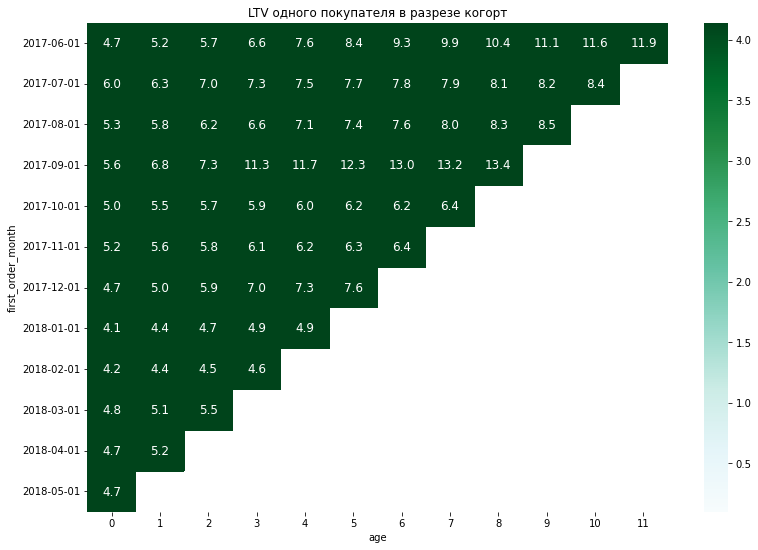

In [101]:
plt.figure(figsize=(13, 9))
plt.title('LTV одного покупателя в разрезе когорт')
ax = sns.heatmap(
    output,
    annot=True,
    fmt='.1f',
    cmap = 'BuGn',    
    vmax=.1,
    annot_kws={'fontsize':12}
)
ticklabels=[output.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);

В среднем, шестимесячный ltv схож у всех когорт за исключением сентябрьской с аномально большим ltv (могла быть предновогодняя рекламная кампания для группы пользователей, как гипотеза). LTV поздних когорт имеет тенденцию к снижению и в начале жизни, и на последний анализируемый месяц.

### Маркетинговые метрики

#### Анализ маркетинговых расходов

In [102]:
costs['month'] = costs['dt'].astype('datetime64[M]')

Добавим поле "месяц" в датафрейм с расходами.

In [103]:
costs['costs'].sum()

329131.62

Общая сумма расходов на маркетинг за исследуемый период составила 329131.62 условных единиц.

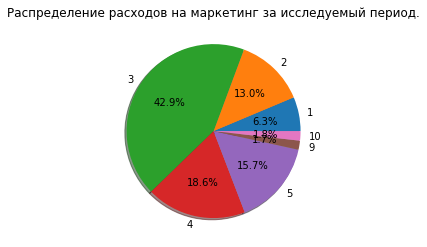

In [104]:
costs_pivot_total = costs.pivot_table(index = 'source_id', values = 'costs',aggfunc = 'sum').reset_index()
plt.title('Распределение расходов на маркетинг за исследуемый период.')
plt.pie(costs_pivot_total['costs'], labels =costs_pivot_total['source_id'],autopct='%1.1f%%',shadow = True);

Сформируем сводную таблицу с распределением затрат по рекламным источникам и построим круговую диаграмму для оценки доли затрат на каждый источник. Диаграмма показывает, что основные затраты приходятся на 3 источник трафика. Далее - 4, 5 и 2. Затраты на 1, 10 и 9 - наименее значительны, их можно анализировать в последнюю очередь.

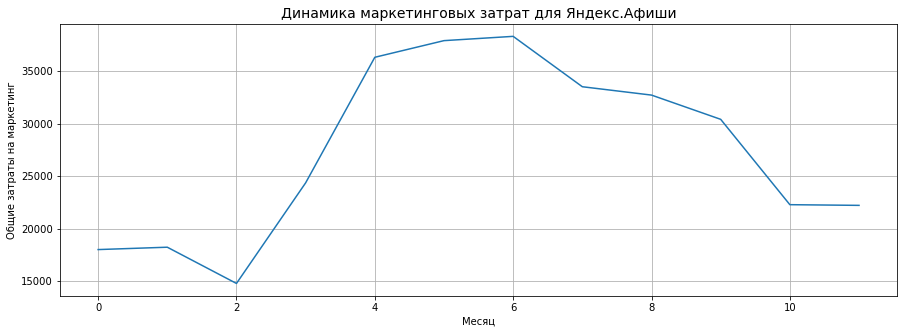

In [105]:
costs_pivot_total_month = costs.pivot_table(index = 'month', values = 'costs',aggfunc = 'sum').reset_index()
costs_pivot_total_month['costs'].plot(figsize = (15,5),grid = True).legend().set_visible(False)
plt.xlabel("Месяц")
plt.ylabel("Общие затраты на маркетинг")
plt.title('Динамика маркетинговых затрат для Яндекс.Афиши', fontsize = 14);

Проанализируем динамику общих маркетинговых затрат. Минимальные затраты - в начале периода, июнь-август. Далее - рост до новогодних праздников (максимум - в декабре) и постепенный спад. Если сравнить диаграмму метрики MAU и диаграмму расходов на маркетинг, их формы практически идентичны. Вывод: можно выдвинуть гипотезу о прямой связи количества пользователей и маркетингового бюджета.

In [132]:
costs_pivot_sources_month = costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs',aggfunc = 'sum').reset_index()

costs_pivot_sources_month

source_id,month,1,2,3,4,5,9,10
0,2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
1,2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2,2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
3,2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
4,2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
5,2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
6,2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
7,2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
8,2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88
9,2018-03-01,1893.09,3943.14,13080.85,5961.87,4529.62,480.29,526.41


#### Анализ среднего САС на одного пользователя.

##### Анализ среднего САС на одного пользователя для всего проекта.

In [107]:
costs_pivot_month = costs.pivot_table(index = 'month', values = 'costs',aggfunc = 'sum').reset_index()

Сформируем сводную с помесячными расходами.

In [108]:
orders_pivot_month = orders.pivot_table(index = 'order_month', values ='uid', aggfunc = [lambda u: u.nunique(),]).reset_index()


In [109]:
orders_pivot_month.columns = ['order_month', 'uid']

Сформируем сводную с помесячным количеством уникальных пользователей.

In [110]:
co_cac_total_df = orders_pivot_month.merge(costs_pivot_month, left_on='order_month', right_on='month')
co_cac_total_df

,order_month,uid,month,costs
0,2017-06-01,2023,2017-06-01,18015.00
1,2017-07-01,1984,2017-07-01,18240.59
2,2017-08-01,1472,2017-08-01,14790.54
3,2017-09-01,2750,2017-09-01,24368.91
4,2017-10-01,4675,2017-10-01,36322.88
5,2017-11-01,4547,2017-11-01,37907.88
6,2017-12-01,4942,2017-12-01,38315.35
7,2018-01-01,3898,2018-01-01,33518.52
8,2018-02-01,4258,2018-02-01,32723.03
9,2018-03-01,4181,2018-03-01,30415.27


Объединим датафреймы с уникальным количеством покупателей и помесячными расходами на маркетинг.

In [111]:
co_cac_total_df['cac_total'] = co_cac_total_df['costs']/co_cac_total_df['uid']

Добавим вычисляемое поле с САС в датафрейм.

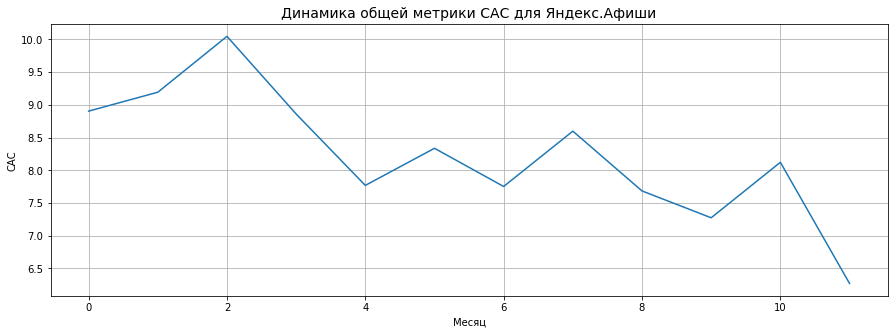

In [112]:
co_cac_total_df['cac_total'].plot(figsize = (15,5),grid = True).legend().set_visible(False)
plt.xlabel("Месяц")
plt.ylabel("САС")
plt.title('Динамика общей метрики САС для Яндекс.Афиши', fontsize = 14);

In [113]:
co_cac_total_df.sort_values(by = 'cac_total', ascending = False)

,order_month,uid,month,costs,cac_total
2,2017-08-01,1472,2017-08-01,14790.54,10.047921
1,2017-07-01,1984,2017-07-01,18240.59,9.193846
0,2017-06-01,2023,2017-06-01,18015.00,8.905091
3,2017-09-01,2750,2017-09-01,24368.91,8.861422
7,2018-01-01,3898,2018-01-01,33518.52,8.598902
5,2017-11-01,4547,2017-11-01,37907.88,8.336899
10,2018-04-01,2744,2018-04-01,22289.38,8.122952
4,2017-10-01,4675,2017-10-01,36322.88,7.769600
6,2017-12-01,4942,2017-12-01,38315.35,7.753005
8,2018-02-01,4258,2018-02-01,32723.03,7.685070


Наиболее высокая стоимость привлечения клиента была в августе, июле и июне. Наименьшая - в мае, марте и феврале. Основная причина - небольшое количество уникальных клиентов в августе, июле и июне. За счет роста количества уникальных покупателей CAC в динамике имеет тенденцию к снижению.

##### Анализ среднего САС на одного пользователя в разрезе источников трафика.

Для удобства последующего расчета ROMI в этом блоке вместе с САС предлагается рассчитать LTV в разрезе источников трафика и когорт.

In [114]:
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

Определим источники трафика для каждого уникального пользователя.

In [115]:
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index() 
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

Добавим в датафрейм с заказами источники из сводной sources. Переименуем для удобства столбцы в таблице payers.

In [116]:
ltv_sources = payers.merge(orders, on = 'uid') 
ltv_sources['lifetime'] = ((ltv_sources['buy_ts'] - ltv_sources['first_buy']) / np.timedelta64(1, 'M')).round().astype(int)


Посчитаем LTV в разрезе источников трафика. Добавим в объединенный датафрейм ltv_sources вычисляемый столбец lifetime.

In [117]:
orders_lifetime = ltv_sources.pivot_table(index = 'source_id', columns = 'cohort_lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
orders_lifetime

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,3495.0,318.0,260.0,255.0,170.0,174.0,161.0,120.0,121.0,64.0,59.0,26.0
2,4307.0,658.0,423.0,269.0,212.0,143.0,120.0,92.0,70.0,41.0,34.0,23.0
3,11680.0,560.0,295.0,220.0,157.0,114.0,93.0,75.0,44.0,19.0,15.0,17.0
4,11483.0,410.0,231.0,197.0,157.0,136.0,128.0,52.0,39.0,32.0,18.0,11.0
5,7890.0,336.0,228.0,204.0,188.0,125.0,150.0,120.0,79.0,57.0,20.0,9.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1265.0,88.0,68.0,59.0,52.0,42.0,24.0,17.0,21.0,8.0,3.0,0.0
10,1466.0,34.0,14.0,17.0,9.0,4.0,6.0,7.0,3.0,2.0,0.0,0.0


Посчитаем суммарную выручку в разрезе когорт.

In [118]:
buyers_lifetime = ltv_sources.pivot_table(index = 'source_id', columns = 'cohort_lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
buyers_lifetime

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,2899.0,129.0,85.0,70.0,45.0,49.0,34.0,31.0,25.0,13.0,15.0,10.0
2,3506.0,183.0,121.0,98.0,94.0,75.0,58.0,40.0,25.0,17.0,16.0,13.0
3,10473.0,328.0,213.0,141.0,119.0,85.0,81.0,65.0,39.0,17.0,15.0,14.0
4,10295.0,323.0,191.0,157.0,113.0,92.0,70.0,44.0,31.0,25.0,13.0,9.0
5,6931.0,201.0,123.0,91.0,79.0,55.0,44.0,36.0,25.0,17.0,9.0,7.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1088.0,73.0,58.0,43.0,41.0,24.0,19.0,12.0,14.0,8.0,3.0,0.0
10,1329.0,29.0,14.0,13.0,7.0,4.0,6.0,6.0,3.0,1.0,0.0,0.0


Посчитаем количество уникальных покупателей в разрезе когорт.

In [119]:
ltv_sources = ltv_sources.pivot_table(index = 'source_id', columns = 'cohort_lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv_sources

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,18103.37,2671.98,2282.85,2110.42,1172.91,733.03,746.61,1061.59,951.02,561.96,377.39,317.42
2,23177.60,4971.97,5632.24,5655.43,2457.37,1863.43,1283.84,691.52,463.03,230.44,394.92,101.82
3,47009.04,2825.65,1520.43,1033.09,744.13,497.94,282.90,260.29,195.57,75.26,46.41,20.53
4,46897.78,1923.59,984.77,1355.08,1036.17,1134.74,1774.10,415.95,196.13,404.65,535.39,35.06
5,33552.31,1749.37,1426.18,10401.37,1374.16,1688.91,873.72,597.71,352.36,471.58,91.56,44.79
7,1.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,4235.05,307.39,301.70,241.94,155.52,139.10,118.13,89.49,142.98,18.75,9.35,0.00
10,4204.68,86.47,36.47,51.38,23.84,13.29,11.18,16.30,3.36,3.36,0.00,0.00


Посчитаем суммарную выручку в разрезе когорт и источников трафика.

In [120]:
ltv_sources = ltv_sources.cumsum(axis = 1)

Посчитаем LTV нарастающим итогом.

In [121]:
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})

Добавим размеры когорт по источникам.

In [122]:
ltv_sources = ltv_sources.merge(cohort_sizes, on = 'source_id') 

In [123]:
ltv_sources = ltv_sources.div(ltv_sources['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv_sources

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.244695,7.166385,7.953846,8.681828,9.086419,9.339276,9.596816,9.963008,10.291059,10.484905,10.615085,10.724577
2,6.610839,8.028970,9.635428,11.248500,11.949404,12.480901,12.847085,13.044324,13.176392,13.242119,13.354760,13.383802
3,4.488594,4.758397,4.903573,5.002216,5.073268,5.120814,5.147826,5.172679,5.191353,5.198539,5.202970,5.204931
4,4.555394,4.742241,4.837896,4.969521,5.070169,5.180391,5.352718,5.393121,5.412172,5.451477,5.503482,5.506888
5,4.840905,5.093303,5.299071,6.799773,6.998036,7.241711,7.367771,7.454008,7.504846,7.572886,7.586096,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.892509,4.175037,4.452335,4.674706,4.817647,4.945496,5.054072,5.136324,5.267739,5.284972,5.293566,5.293566
10,3.163792,3.228856,3.256298,3.294959,3.312897,3.322897,3.331309,3.343574,3.346102,3.348631,3.348631,3.348631


Объединим датафрейм ltv_sources с размерами когорт и поделим валовую прибыль в разрезе когорт и источников привлечения на количество уникальных пользователей в аналогичном разрезе.

In [124]:
cac_sources = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id') 

Сгруппируем затраты по источникам трафика и объединим с размером когорт.

In [125]:
cac_sources['cac'] = cac_sources['costs'] / cac_sources['cohort_size']

Добавим в датафрейм расчетный столбец с САС.

In [126]:
cac_sources

,source_id,costs,cohort_size,cac
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10295,5.932356
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106


Проанализируем САС в разрезе источников трафика. Трафик, привлеченный через третий источник - максимальный, размер когорты 10 473 уникальных покупателя. Но и расходы на этот источник максимальны, 141 321 условных единиц и 12,2 у.е. на пользователя. Почти такой же трафик генерирует и 4 источник, но при более чем вдвое меньших расходах. Его можно назвать наиболее перспективным и рекомендовать увеличить расходы для увеличения трафика. Третий по величине источник (5) также выглядит перспективным, 6 931 уникальных пользователей при расходах 7,46 на 1 покупателя. Источник средней перспективности - номер 1, 2899 пользователей при расходах на привлечение 7,18 у.е. Источники 9 и 10 по метрике САС перспективны, расходы на привлечение низкие, 5 и 4,38 у.е., но объем привлеченного трафика невелик, 1088 и 1329 пользователей. Убыточным и бесперспективным выглядит 2 источник, 3506 пользователей при очень высоком САС, 12,2 у.е. на пользователя. Если третий источник при сопоставимом САС хотя бы генерирует большую часть трафика, источник №2 дает в 3 раза меньше трафика при значительных затратах.

#### Расчет ROMI.

In [127]:
romi = ltv_sources.merge(cac_sources, left_on = 'source_id', right_on='source_id')
romi

,source_id,0,1,2,3,4,5,6,7,8,9,10,11,costs,cohort_size,cac
0,1,6.244695,7.166385,7.953846,8.681828,9.086419,9.339276,9.596816,9.963008,10.291059,10.484905,10.615085,10.724577,20833.27,2899,7.186364
1,2,6.610839,8.028970,9.635428,11.248500,11.949404,12.480901,12.847085,13.044324,13.176392,13.242119,13.354760,13.383802,42806.04,3506,12.209367
2,3,4.488594,4.758397,4.903573,5.002216,5.073268,5.120814,5.147826,5.172679,5.191353,5.198539,5.202970,5.204931,141321.63,10473,13.493901
3,4,4.555394,4.742241,4.837896,4.969521,5.070169,5.180391,5.352718,5.393121,5.412172,5.451477,5.503482,5.506888,61073.60,10295,5.932356
4,5,4.840905,5.093303,5.299071,6.799773,6.998036,7.241711,7.367771,7.454008,7.504846,7.572886,7.586096,7.592558,51757.10,6931,7.467479
5,9,3.892509,4.175037,4.452335,4.674706,4.817647,4.945496,5.054072,5.136324,5.267739,5.284972,5.293566,5.293566,5517.49,1088,5.071222
6,10,3.163792,3.228856,3.256298,3.294959,3.312897,3.322897,3.331309,3.343574,3.346102,3.348631,3.348631,3.348631,5822.49,1329,4.381106


Объединим датафреймы с ltv и cac по источнику трафика.

In [128]:
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')

Рассчитаем ROMI, поделим ltv на cac.

In [129]:
romi

,source_id,0,1,2,3,4,5,6,7,8,9,10,11,costs,cohort_size
0,0.139152,0.868964,0.997220,1.106797,1.208097,1.264397,1.299583,1.335420,1.386377,1.432026,1.459000,1.477115,1.492351,2899.0,403.402874
1,0.163809,0.541456,0.657607,0.789183,0.921301,0.978708,1.022240,1.052232,1.068387,1.079204,1.084587,1.093813,1.096191,3506.0,287.156579
2,0.222323,0.332639,0.352633,0.363392,0.370702,0.375968,0.379491,0.381493,0.383335,0.384718,0.385251,0.385579,0.385725,10473.0,776.128389
3,0.674268,0.767890,0.799386,0.815510,0.837698,0.854664,0.873244,0.902292,0.909103,0.912314,0.918940,0.927706,0.928280,10295.0,1735.398355
4,0.669570,0.648265,0.682064,0.709620,0.910585,0.937135,0.969766,0.986648,0.998196,1.005004,1.014115,1.015884,1.016750,6931.0,928.157895
5,1.774720,0.767568,0.823280,0.877961,0.921810,0.949997,0.975208,0.996618,1.012837,1.038751,1.042150,1.043844,1.043844,1088.0,214.543932
6,2.282529,0.722145,0.736996,0.743259,0.752084,0.756178,0.758461,0.760381,0.763180,0.763757,0.764335,0.764335,0.764335,1329.0,303.348052


In [130]:
romi = romi.iloc[:, 0:13]
source_id = ['1','2','3','4','5','9','10']
romi['source_id'] = source_id
romi.set_index('source_id', inplace=True)
romi

<ipython-input-130-315af1ac3e73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romi['source_id'] = source_id


,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.868964,0.997220,1.106797,1.208097,1.264397,1.299583,1.335420,1.386377,1.432026,1.459000,1.477115,1.492351
2,0.541456,0.657607,0.789183,0.921301,0.978708,1.022240,1.052232,1.068387,1.079204,1.084587,1.093813,1.096191
3,0.332639,0.352633,0.363392,0.370702,0.375968,0.379491,0.381493,0.383335,0.384718,0.385251,0.385579,0.385725
4,0.767890,0.799386,0.815510,0.837698,0.854664,0.873244,0.902292,0.909103,0.912314,0.918940,0.927706,0.928280
5,0.648265,0.682064,0.709620,0.910585,0.937135,0.969766,0.986648,0.998196,1.005004,1.014115,1.015884,1.016750
9,0.767568,0.823280,0.877961,0.921810,0.949997,0.975208,0.996618,1.012837,1.038751,1.042150,1.043844,1.043844
10,0.722145,0.736996,0.743259,0.752084,0.756178,0.758461,0.760381,0.763180,0.763757,0.764335,0.764335,0.764335


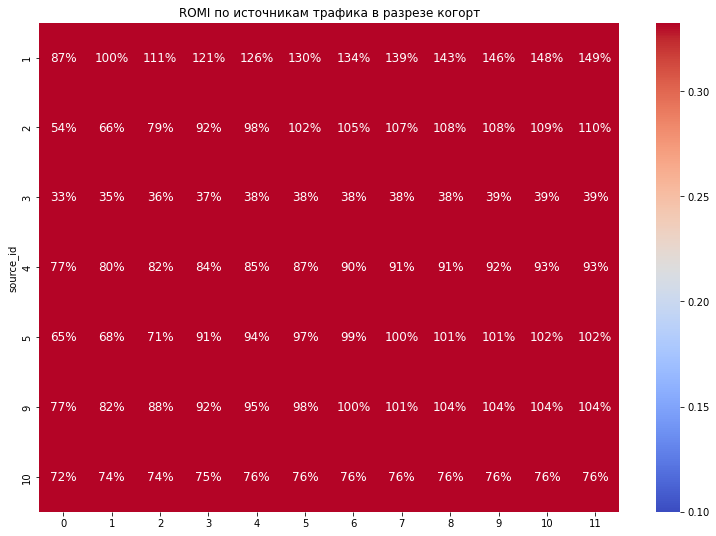

In [131]:
plt.figure(figsize=(13, 9))
plt.title('ROMI по источникам трафика в разрезе когорт')
ax = sns.heatmap(
    romi,
    annot=True,
    fmt='.0%',
    cmap = 'coolwarm',    
    vmax=.1,
    annot_kws={'fontsize':12}
);

Проанализируем ROMI по источникам. Быстрее всего окупился первый источник (на третий месяц). Следующий - источник №2 на шестой месяц. Источник 9 окупился на 8 месяц. На 9 месяц окупился источник 5. Остальные источники не окупились за 12 месяцев, хотя наиболее близок к этому четвертый источник, второй по величине источник трафика. Наиболее далеки от окупаемости 10 и 3 источники.

## Выводы и рекомендации.

### Перспективные источники трафика.

Наиболее "массовый" источник трафика - №3, через него идет самый широкий поток трафика. Но его САС высок и ROMI показывает, что к 12 месяцу он еще не окупился, стоимость привлечения выше генерируемой валовой прибыли. Первый по перспективности - источник №4, он генерирует почти такую же прибыль, но привлечение дешевле более чем вдвое. К 12 месяцу его ROMI = 93%, он почти окупился. Источник №5 также перспективен, он генерирует меньше трафика, чем 4 источник, но при невысоком САС 7,46 на пользователя он окупился к 7 месяцу. Источники твердой средней привлекательности - 1, 9 и 10. Не очень высокие значения САС, окупились и близки к окупаемости все, источник №1 - лидер по скорости окупаемости. Но их трафик не такой массовый, как у лидеров привлечения - 4, 3 и 5. Источник 2 окупился, но его САС очень велик, 12,2 у.е. на одного пользователя, привлеченный трафик же ближе к аутсайдерам по трафику, чем к лидерам.
Необходимо также отметить, что источники 1, 2 и 5 - в первой тройке по объему валовой прибыли на 1 пользователя, этот момент маркетологам также надо учесть.

### Выводы в разрезе метрик.

#### Продуктовые метрики.

Анализ продуктовых метрик показывает, что сервис с 2017 по 2018 год вырос, (количество посетителей сайта 13 259 в июне 2017 и 20 701 в мае 2018, также mau за первое полугодие 2018 ближе к среднемесячному mau, 23228). Резкий рост, начиная с осенних месяцев и до новогодних праздников можно объяснить тем, что в холодное время года люди более склонны к посещению концертов, театров и кинотеатров, основные гастрольные туры также в большей степени проходят в это время (гипотеза). Спад в весенне-летний период скорее всего связан с сезоном отпусков и желанием проводить больше времемни на открытом воздухе (также гипотеза). Недельная метрика WAU показывает самые высокие значения посещений сайта с 40 по 52 (последнюю в году) неделю. Это частично подтверждает гипотезу о том, что в осенний и предновогодний период людид активно посещают развлекательные мероприятия. Начиная с новогодних праздников посещаемость идет на спад. Небольшие пики наблюдаются в период праздников 23 февраля и 8 марта.

Среднее количество сессий в день - 1.082 на пользователя. Распределение более-менее равномерное, но заметен пик во время новогодних праздников.

Наиболее часто встречающееся значение длительности пользовательской сессии - 60 секунд.

Retention Rate достаточно стабилен с течением времени. Для летних когорт он немного растет, для зимних - падает, что может быть обусловлено сезонностью мероприятий (основные мероприятия проходят в осенне-зимний период).

#### Метрики электронной коммерции.

Анализ показал, что типичное время от первого посещения до покупки на сайте Яндекс.Афиша - 60 секунд.

Среднее количество покупок на 1 человека за 6 месяцев = 1,91.  Минимальное количество заказов происходит в первый месяц жизни когорты. Со временем почти в каждой когорте количество средних покупок на 1 пользователя растет. Первая когорта (июнь 2017 г). показывает максимальные показатели по заказам на пользователя.

Средняя выручка на 1 пользователя - 5 условных единиц. Максимальный средний чек - в сентябре, декабре и марте (возможно это связано с праздничными днями).

Анализ LTV показал, что в среднем каждый покупатель за 6 месяцев жизни когорты принес 7,97 условных единиц прибыли. 
Первый месяц жизни когорт характеризуется максимальной отдачей. В среднем, шестимесячный ltv схож у всех когорт за исключением сентябрьской с аномально большим ltv декабря (могла быть предновогодняя рекламная кампания для группы пользователей, как гипотеза). 

#### Маркетинговые метрики.

Общая сумма расходов на маркетинг за исследуемый период составила 329131.62 условных единиц. Распределение затрат по источникам трафика: основные затраты приходятся на 3 источник трафика. Далее - 4, 5 и 2. Затраты на 1, 10 и 9 - наименее значительны.

Динамика маркетинговых затрат за весь исследуемый период: минимальные затраты - в начале периода, июнь-август. Далее - рост до новогодних праздников (максимум - в декабре) и постепенный спад. Если сравнить диаграмму метрики MAU и диаграмму расходов на маркетинг, их формы практически идентичны. Вывод: можно выдвинуть гипотезу о прямой связи количества пользователей и маркетингового бюджета.

Анализ динамики САС показывает, что наиболее высокая стоимость привлечения клиента была в августе, июле и июне. Наименьшая - в мае, марте и феврале. Основная причина - небольшое количество уникальных клиентов в августе, июле и июне. За счет роста количества уникальных покупателей CAC в динамике имеет тенденцию к снижению.

Анализ САС в разрезе источников трафика показывает, что трафик, привлеченный через третий источник - максимальный, размер когорты 10 473 уникальных покупателя. Но и расходы на этот источник максимальны, 141 321 условных единиц и 12,2 у.е. на пользователя. Почти такой же трафик генерирует и 4 источник, но при более чем вдвое меньших расходах. Его можно назвать наиболее перспективным и рекомендовать увеличить расходы для увеличения трафика. Третий по величине источник (5) также выглядит перспективным, 6 931 уникальных пользователей при расходах 7,46 на 1 покупателя. Источник средней перспективности - номер 1, 2899 пользователей при расходах на привлечение 7,18 у.е. Источники 9 и 10 по метрике САС перспективны, расходы на привлечение низкие, 5 и 4,38 у.е., но объем привлеченного трафика невелик, 1088 и 1329 пользователей. Убыточным и бесперспективным выглядит 2 источник, 3506 пользователей при очень высоком САС, 12,2 у.е. на пользователя. Если третий источник при сопоставимом САС хотя бы генерирует большую часть трафика, источник №2 дает в 3 раза меньше трафика при значительных затратах.

Анализ ROMI в разрезе источников трафика показал, что быстрее всего окупился первый источник (на третий месяц). Следующий - источник №2 на шестой месяц. Источник 9 окупился на 8 месяц. На 9 месяц окупился источник 5. Остальные источники не окупились за 12 месяцев, хотя наиболее близок к этому четвертый источник, второй по величине источник трафика. Наиболее далеки от окупаемости 10 и 3 источники.

### Итоги когортного анализа.

Retention Rate имеет тенденцию к снижению с течением времени. Наиболее стабильна первая (июньская) когорта. Можно также отметить сентябрьскую когорту, как удерживающую максимальную посещаемость на второй и третий месяц существования. ltv схож у всех когорт за исключением сентябрьской с аномально большим ltv декабря (могла быть предновогодняя рекламная кампания для группы пользователей, как гипотеза). Средний ltv октябрьской и ноябрьской когорт - минимальный, если рассматривать шестимесячный период.

В большей степени интерес представляют когорты на основе источников трафика, выводы по ним изложены в п. 3.2.3.